In [ ]:
import pandas as pd
df= pd.read_csv("landing_gear_rul_clean.csv")

In [ ]:
df.head()

,load_during_landing,taxiing_duration,speed_during_landing,braking_force,tire_pressure,hydraulic_pressure,RUL,runway_condition_snowy,runway_condition_wet
0,54.236163,15.965111,122.654470,38.793007,37.690533,2735.909048,498,0,0
1,44.444236,13.550394,129.396489,35.113165,36.719455,2965.584917,498,0,0
2,56.596049,17.598667,163.282770,40.849790,37.762192,3004.009782,498,1,0
3,46.482830,8.758626,166.841213,34.088577,33.600488,3109.072900,498,1,0
4,74.698720,12.252277,142.424981,56.753035,33.510114,2954.852037,498,0,0


In [ ]:
df.shape

(10000, 9)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    ExtraTreesRegressor
)

In [ ]:
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.5 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
TARGET = "RUL"
assert TARGET in df.columns, "RUL column not found."

In [ ]:
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

In [ ]:
from typing import List
numeric_cols: List[str] = X.columns.tolist()

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols)],
    remainder="drop"
)

In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

def kfold_mae(model_name, make_model_fn, X_df, y_series, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    maes = []

    for tr_idx, va_idx in kf.split(X_df):
        X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
        y_tr, y_va = y_series.iloc[tr_idx], y_series.iloc[va_idx]

        pre = preprocessor.fit(X_tr, y_tr)
        X_tr_f = pre.transform(X_tr)
        X_va_f = pre.transform(X_va)

        model = make_model_fn()

        if model_name == "XGBoost":
            model.set_params(**{"eval_metric": "mae"})
            model.fit(
                X_tr_f, y_tr,
                eval_set=[(X_va_f, y_va)],
                verbose=False,
            )
        elif model_name == "LightGBM":
            try:
                model.fit(
                    X_tr_f, y_tr,
                    eval_set=[(X_va_f, y_va)],
                    eval_metric="mae",
                    verbose=False,
                    early_stopping_rounds=100
                )
            except TypeError:
                model.fit(X_tr_f, y_tr)
        elif model_name == "CatBoost":
            try:
                model.set_params(loss_function="MAE")
            except Exception:
                pass
            model.fit(
                X_tr_f, y_tr,
                eval_set=(X_va_f, y_va),
                use_best_model=True,
                verbose=False
            )
        else:
            model.fit(X_tr_f, y_tr)

        y_hat = model.predict(X_va_f)
        maes.append(mean_absolute_error(y_va, y_hat))

    return float(np.mean(maes))

In [ ]:
def objective(trial: optuna.Trial):

    candidates = [
        "DecisionTree",
        "RandomForest",
        "ExtraTrees",
        "GradientBoosting",
        "HistGradientBoosting",
        "Ridge",
        "Lasso",
        "SVR",
    ]
    if HAS_XGB:  candidates.append("XGBoost")
    if HAS_LGBM: candidates.append("LightGBM")
    if HAS_CAT:  candidates.append("CatBoost")

    model_name = trial.suggest_categorical("model", candidates)


    def make_model():
        if model_name == "DecisionTree":
            return DecisionTreeRegressor(
                max_depth=trial.suggest_int("dt_max_depth", 2, 40),
                min_samples_split=trial.suggest_int("dt_min_samples_split", 2, 20),
                min_samples_leaf=trial.suggest_int("dt_min_samples_leaf", 1, 10),
                random_state=42
            )

        if model_name == "RandomForest":
            return RandomForestRegressor(
                n_estimators=trial.suggest_int("rf_n_estimators", 200, 1200),
                max_depth=trial.suggest_int("rf_max_depth", 4, 40),
                min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 20),
                min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 10),
                max_features=trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None]),
                n_jobs=-1, random_state=42
            )

        if model_name == "ExtraTrees":
            return ExtraTreesRegressor(
                n_estimators=trial.suggest_int("et_n_estimators", 200, 1200),
                max_depth=trial.suggest_int("et_max_depth", 4, 40),
                min_samples_split=trial.suggest_int("et_min_samples_split", 2, 20),
                min_samples_leaf=trial.suggest_int("et_min_samples_leaf", 1, 10),
                max_features=trial.suggest_categorical("et_max_features", ["sqrt", "log2", None]),
                bootstrap=trial.suggest_categorical("et_bootstrap", [False, True]),
                n_jobs=-1, random_state=42
            )

        if model_name == "GradientBoosting":
            return GradientBoostingRegressor(
                n_estimators=trial.suggest_int("gbrt_n_estimators", 200, 1500),
                learning_rate=trial.suggest_float("gbrt_lr", 1e-3, 0.3, log=True),
                max_depth=trial.suggest_int("gbrt_max_depth", 2, 8),
                subsample=trial.suggest_float("gbrt_subsample", 0.6, 1.0),
                random_state=42
            )

        if model_name == "HistGradientBoosting":
            return HistGradientBoostingRegressor(
                max_depth=trial.suggest_int("hgb_max_depth", 3, 40),
                learning_rate=trial.suggest_float("hgb_lr", 1e-3, 0.3, log=True),
                max_iter=trial.suggest_int("hgb_iter", 200, 2000),
                min_samples_leaf=trial.suggest_int("hgb_min_leaf", 10, 200),
                l2_regularization=trial.suggest_float("hgb_l2", 0.0, 1.0),
                random_state=42
            )

        if model_name == "Ridge":
            return Ridge(
                alpha=trial.suggest_float("ridge_alpha", 1e-3, 1e3, log=True),
                random_state=42
            )

        if model_name == "Lasso":
            return Lasso(
                alpha=trial.suggest_float("lasso_alpha", 1e-4, 10.0, log=True),
                random_state=42, max_iter=20000
            )

        if model_name == "SVR":
            return SVR(
                C=trial.suggest_float("svr_C", 1e-2, 1e3, log=True),
                epsilon=trial.suggest_float("svr_epsilon", 1e-3, 1.0, log=True),
                gamma=trial.suggest_categorical("svr_gamma", ["scale", "auto"]),
                kernel=trial.suggest_categorical("svr_kernel", ["rbf", "poly"]),
                degree=trial.suggest_int("svr_degree", 2, 5)
            )

        if model_name == "XGBoost":
            return XGBRegressor(
                n_estimators=trial.suggest_int("xgb_n_estimators", 300, 3000),
                learning_rate=trial.suggest_float("xgb_lr", 1e-3, 0.3, log=True),
                max_depth=trial.suggest_int("xgb_max_depth", 3, 12),
                min_child_weight=trial.suggest_float("xgb_min_child_weight", 1.0, 20.0),
                subsample=trial.suggest_float("xgb_subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("xgb_colsample", 0.5, 1.0),
                reg_lambda=trial.suggest_float("xgb_lambda", 1e-3, 100.0, log=True),
                reg_alpha=trial.suggest_float("xgb_alpha", 1e-6, 10.0, log=True),
                gamma=trial.suggest_float("xgb_gamma", 0.0, 5.0),
                tree_method="hist",
                n_jobs=-1,
                random_state=42
            )

        if model_name == "LightGBM":
            return LGBMRegressor(
                n_estimators=trial.suggest_int("lgb_n_estimators", 300, 3000),
                learning_rate=trial.suggest_float("lgb_lr", 1e-3, 0.3, log=True),
                num_leaves=trial.suggest_int("lgb_num_leaves", 15, 255),
                max_depth=trial.suggest_int("lgb_max_depth", -1, 32),  # -1 means no limit
                min_child_samples=trial.suggest_int("lgb_min_child_samples", 5, 100),
                subsample=trial.suggest_float("lgb_subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("lgb_colsample", 0.5, 1.0),
                reg_lambda=trial.suggest_float("lgb_lambda", 1e-3, 100.0, log=True),
                reg_alpha=trial.suggest_float("lgb_alpha", 1e-6, 10.0, log=True),
                n_jobs=-1,
                random_state=42
            )

        if model_name == "CatBoost":
            return CatBoostRegressor(
                iterations=trial.suggest_int("cat_iter", 500, 4000),
                learning_rate=trial.suggest_float("cat_lr", 1e-3, 0.3, log=True),
                depth=trial.suggest_int("cat_depth", 4, 10),
                l2_leaf_reg=trial.suggest_float("cat_l2", 1.0, 20.0),
                loss_function="RMSE",
                random_state=42,
                verbose=False,
                od_type="Iter",
                od_wait=100
            )

        raise ValueError("Unknown model")


    return kfold_mae(model_name, make_model, X_train_all, y_train_all, n_splits=5, random_state=42)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="rul_multi_model")
study.optimize(objective, n_trials=150, show_progress_bar=True)

print("\nBest Trial")
print("==========")
print(f"MAE : {study.best_value:.4f}")
print("Params:", study.best_params)

[I 2025-10-11 15:41:47,581] A new study created in memory with name: rul_multi_model


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-10-11 15:42:06,008] Trial 0 finished with value: 57.87111271911291 and parameters: {'model': 'ExtraTrees', 'et_n_estimators': 612, 'et_max_depth': 39, 'et_min_samples_split': 11, 'et_min_samples_leaf': 1, 'et_max_features': 'log2', 'et_bootstrap': False}. Best is trial 0 with value: 57.87111271911291.
[I 2025-10-11 15:42:06,220] Trial 1 finished with value: 59.14633732229705 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.03068024017577707}. Best is trial 0 with value: 57.87111271911291.
[I 2025-10-11 15:42:47,185] Trial 2 finished with value: 60.87946073657274 and parameters: {'model': 'XGBoost', 'xgb_n_estimators': 2820, 'xgb_lr': 0.060982312083666404, 'xgb_max_depth': 8, 'xgb_min_child_weight': 5.854960723962655, 'xgb_subsample': 0.9757766997340787, 'xgb_colsample': 0.9593735476174687, 'xgb_lambda': 0.06088978609171985, 'xgb_alpha': 0.0012113885086464547, 'xgb_gamma': 2.3144745418978556}. Best is trial 0 with value: 57.87111271911291.
[I 2025-10-11 15:44:01,288] Trial 3 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 15:49:58,681] Trial 9 finished with value: 79.71525488993989 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 574, 'lgb_lr': 0.0013687772627977918, 'lgb_num_leaves': 102, 'lgb_max_depth': 13, 'lgb_min_child_samples': 45, 'lgb_subsample': 0.8720704776137524, 'lgb_colsample': 0.9729687847083552, 'lgb_lambda': 14.374772145426487, 'lgb_alpha': 0.0019637904131537594}. Best is trial 8 with value: 57.58553889515647.
[I 2025-10-11 15:50:12,774] Trial 10 finished with value: 112.01622502293512 and parameters: {'model': 'SVR', 'svr_C': 0.05997162969438447, 'svr_epsilon': 0.0012461405553693663, 'svr_gamma': 'auto', 'svr_kernel': 'rbf', 'svr_degree': 4}. Best is trial 8 with value: 57.58553889515647.
[I 2025-10-11 15:51:28,404] Trial 11 finished with value: 57.671465727154114 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 975, 'rf_max_depth': 27, 'rf_min_samples_split': 16, 'rf_min_samples_leaf': 4, 'rf_max_features': 'log2'}. Best is trial 8 with value: 57.585

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 15:54:59,603] Trial 18 finished with value: 67.27353278064167 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 2917, 'lgb_lr': 0.2888490007383871, 'lgb_num_leaves': 254, 'lgb_max_depth': 31, 'lgb_min_child_samples': 93, 'lgb_subsample': 0.5477227125731492, 'lgb_colsample': 0.5097430525154468, 'lgb_lambda': 0.0029601090782515314, 'lgb_alpha': 5.717404557360978}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 15:54:59,956] Trial 19 finished with value: 62.28471438783926 and parameters: {'model': 'DecisionTree', 'dt_max_depth': 3, 'dt_min_samples_split': 20, 'dt_min_samples_leaf': 2}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 15:55:00,165] Trial 20 finished with value: 59.97653552464702 and parameters: {'model': 'Lasso', 'lasso_alpha': 7.3588540389222965}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 15:55:20,075] Trial 21 finished with value: 56.99799397923257 and parameters: {'model': 'GradientBoosting', 'gbrt_n_

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 16:06:42,194] Trial 45 finished with value: 59.09102702264296 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 2267, 'lgb_lr': 0.03243173553488747, 'lgb_num_leaves': 28, 'lgb_max_depth': 0, 'lgb_min_child_samples': 12, 'lgb_subsample': 0.9569441810778766, 'lgb_colsample': 0.7524450328235073, 'lgb_lambda': 67.10471882737676, 'lgb_alpha': 6.402118211465874e-06}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:08:36,190] Trial 46 finished with value: 77.46835632923738 and parameters: {'model': 'SVR', 'svr_C': 73.8348749454237, 'svr_epsilon': 0.008942735464659863, 'svr_gamma': 'scale', 'svr_kernel': 'poly', 'svr_degree': 5}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:09:14,292] Trial 47 finished with value: 57.03339095377987 and parameters: {'model': 'GradientBoosting', 'gbrt_n_estimators': 329, 'gbrt_lr': 0.041312889533906334, 'gbrt_max_depth': 3, 'gbrt_subsample': 0.873802785729707}. Best is trial 12 with value: 56.97517784276

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 16:15:48,196] Trial 60 finished with value: 88.03164291087325 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 391, 'lgb_lr': 0.001561532314970042, 'lgb_num_leaves': 215, 'lgb_max_depth': 31, 'lgb_min_child_samples': 96, 'lgb_subsample': 0.6128666298636564, 'lgb_colsample': 0.530117444311819, 'lgb_lambda': 0.0010023029717129738, 'lgb_alpha': 8.824003146251055}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:16:08,125] Trial 61 finished with value: 57.01460962056185 and parameters: {'model': 'GradientBoosting', 'gbrt_n_estimators': 214, 'gbrt_lr': 0.04142440567711469, 'gbrt_max_depth': 2, 'gbrt_subsample': 0.9986457711682486}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:16:33,050] Trial 62 finished with value: 57.064492544006534 and parameters: {'model': 'GradientBoosting', 'gbrt_n_estimators': 273, 'gbrt_lr': 0.07383217990800788, 'gbrt_max_depth': 2, 'gbrt_subsample': 0.9986678557113351}. Best is trial 12 with value: 56.9751

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 16:31:54,983] Trial 87 finished with value: 60.111062960151436 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 1472, 'lgb_lr': 0.017933698191492896, 'lgb_num_leaves': 151, 'lgb_max_depth': 0, 'lgb_min_child_samples': 9, 'lgb_subsample': 0.7474299299265439, 'lgb_colsample': 0.9873944955490567, 'lgb_lambda': 0.299579286508192, 'lgb_alpha': 2.676765362774855e-06}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:32:27,005] Trial 88 finished with value: 57.759570319017186 and parameters: {'model': 'GradientBoosting', 'gbrt_n_estimators': 206, 'gbrt_lr': 0.016045631010779673, 'gbrt_max_depth': 4, 'gbrt_subsample': 0.9103934075121067}. Best is trial 12 with value: 56.97517784276032.
[I 2025-10-11 16:32:46,066] Trial 89 finished with value: 70.76548655334503 and parameters: {'model': 'HistGradientBoosting', 'hgb_max_depth': 24, 'hgb_lr': 0.0010063616162840144, 'hgb_iter': 1079, 'hgb_min_leaf': 106, 'hgb_l2': 0.4674561042020002}. Best is trial 12 with va

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.761719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 246.688906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 249.274844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Start training from score 248.088750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[I 2025-10-11 16:59:45,063] Trial 125 finished with value: 65.3358873516282 and parameters: {'model': 'LightGBM', 'lgb_n_estimators': 1225, 'lgb_lr': 0.2144589265633277, 'lgb_num_leaves': 33, 'lgb_max_depth': 17, 'lgb_min_child_samples': 61, 'lgb_subsample': 0.7041221982312058, 'lgb_colsample': 0.7326311333313347, 'lgb_lambda': 0.22964319410119652, 'lgb_alpha': 0.008176271377171406}. Best is trial 112 with value: 56.89214242420129.
[I 2025-10-11 17:00:50,661] Trial 126 finished with value: 56.91310274362631 and parameters: {'model': 'GradientBoosting', 'gbrt_n_estimators': 830, 'gbrt_lr': 0.01154958362404333, 'gbrt_max_depth': 2, 'gbrt_subsample': 0.8254025447357044}. Best is trial 112 with value: 56.89214242420129.
[I 2025-10-11 17:01:20,242] Trial 127 finished with value: 59.954856720187976 and parameters: {'model': 'HistGradientBoosting', 'hgb_max_depth': 23, 'hgb_lr': 0.024499118128637004, 'hgb_iter': 1895, 'hgb_min_leaf': 126, 'hgb_l2': 0.44060771889679146}. Best is trial 112 with

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae_mean   = mean_absolute_error(y_test, np.full_like(y_test, y_train_all.mean()))
mae_median = mean_absolute_error(y_test, np.full_like(y_test, np.median(y_train_all)))

print(f"Baseline MAE (mean):   {mae_mean:.3f}")
print(f"Baseline MAE (median): {mae_median:.3f}")


Baseline MAE (mean):   125.282
Baseline MAE (median): 125.284


In [ ]:
gbrt_best = GradientBoostingRegressor(
    n_estimators=789,
    learning_rate=0.013065884482111432,
    max_depth=2,
    subsample=0.7981321205958867,
    loss="absolute_error",
    random_state=42
)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", gbrt_best)
])

best_pipe.fit(X_train_all, y_train_all)

y_pred = best_pipe.predict(X_test)

print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²  : {r2_score(y_test, y_pred):.4f}")

MAE : 57.7539
RMSE: 73.8371
R²  : 0.7366


In [ ]:
importances = best_pipe.named_steps["model"].feature_importances_

In [ ]:
importances

array([8.10008829e-01, 1.79502731e-03, 3.35399841e-02, 3.84970097e-03,
       1.46477970e-01, 4.25452342e-03, 1.90387774e-05, 5.49266453e-05])

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_pipe, X_test, y_test, n_repeats=10, random_state=42)
for name, imp in sorted(zip(X_test.columns, r.importances_mean), key=lambda x: -x[1]):
    print(f"{name:25s} {imp:.5f}")


load_during_landing       1.02030
tire_pressure             0.09260
speed_during_landing      0.01102
hydraulic_pressure        0.00011
taxiing_duration          0.00001
runway_condition_snowy    0.00000
runway_condition_wet      -0.00000
braking_force             -0.00028


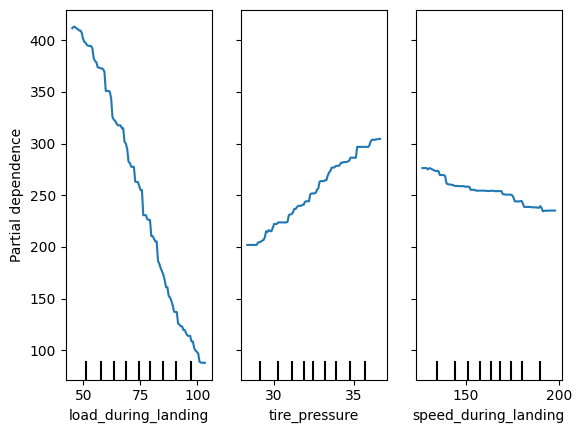

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

PartialDependenceDisplay.from_estimator(best_pipe, X_test,
                                        features=["load_during_landing","tire_pressure","speed_during_landing"])
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

top_feats = ["load_during_landing", "tire_pressure", "speed_during_landing"]

X_train_top = X_train_all[top_feats]
X_test_top  = X_test[top_feats]

preprocessor_top = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), top_feats)
    ],
    remainder="drop"
)

gbrt_best_top = GradientBoostingRegressor(
    n_estimators=789,
    learning_rate=0.013065884482111432,
    max_depth=2,
    subsample=0.7981321205958867,
    loss="absolute_error",
    random_state=42
)

best_pipe_top = Pipeline([
    ("pre", preprocessor_top),
    ("model", gbrt_best_top)
])

best_pipe_top.fit(X_train_top, y_train_all)

y_pred_top = best_pipe_top.predict(X_test_top)

mae_top  = mean_absolute_error(y_test, y_pred_top)
rmse_top = np.sqrt(mean_squared_error(y_test, y_pred_top))
r2_top   = r2_score(y_test, y_pred_top)

print("\n=== Reduced Feature Model (Top 3) ===")
print(f"MAE : {mae_top:.4f}")
print(f"RMSE: {rmse_top:.4f}")
print(f"R²  : {r2_top:.4f}")


=== Reduced Feature Model (Top 3) ===
MAE : 57.7884
RMSE: 73.8354
R²  : 0.7366


In [ ]:
from joblib import dump
dump(best_pipe_top, "best_rul_model_top3.joblib")

['best_rul_model_top3.joblib']

In [ ]:
files.download("best_rul_model_top3.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>